In [1]:
%load_ext autoreload
%autoreload 2
import os

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm
from collections import defaultdict

import numpy as np
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import cdist
from utils.transforms import remove_ornaments, set_adaptive_threshold

import numpy as np
import math
import random


from typing import List, Tuple, Optional

c:\Users\mo\Documents\Organisations\RUG\rug-hr\experiments
c:\Users\mo\Documents\Organisations\RUG\rug-hr


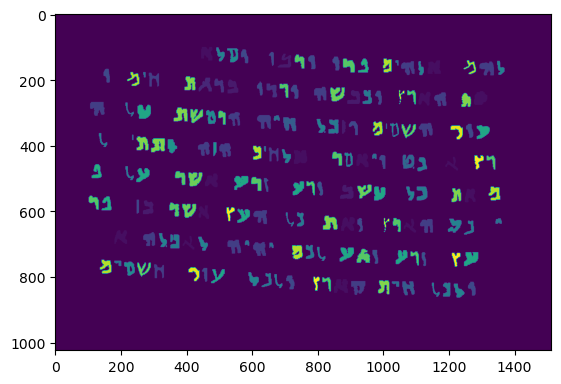

In [2]:
# show random image
masks_folder = "datasets/dss_corrupted/Raw/"
masks = os.listdir(masks_folder)
random_mask = np.random.choice(masks)
image = np.array(Image.open(masks_folder + random_mask))
plt.imshow(image)

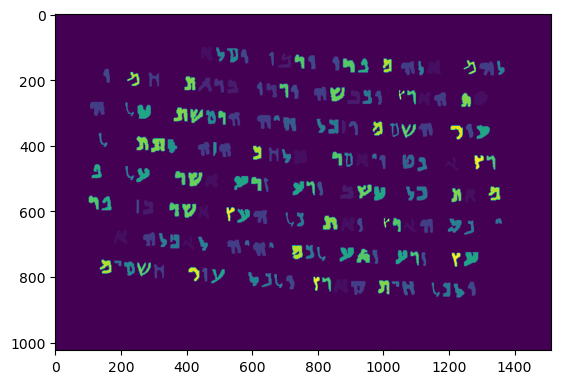

In [3]:
binary_image = np.where(image > 0, 1, 0)
allowed_pixels = remove_ornaments(binary_image, set_adaptive_threshold(binary_image))
image_without_ornaments = np.where(allowed_pixels > 0, image, 0)
plt.imshow(image_without_ornaments)

In [4]:
class Point:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

    def __repr__(self):
        return f'Point({self.x}, {self.y}, "{self.label}")'


In [5]:
def find_centers_of_characters(img: np.ndarray, distance_threshold=0):
    unique_values = np.unique(img)
    unique_values = unique_values[unique_values != 0]  # Exclude background value (0)

    points = []

    for value in unique_values:
        binary_img = np.where(img == value, value, 0).astype(img.dtype)

        # Label connected components
        labeled_img, num_components = label(binary_img)

        # Calculate centers
        value_centers = center_of_mass(binary_img, labeled_img, range(1, num_components + 1))

        # Convert coordinates to integers
        int_centers = [tuple(map(int, center)) for center in value_centers]

        # Merge centers that are close together
        merged_centers = []
        for idx, center in enumerate(int_centers):
            if center in merged_centers:
                continue

            # Find the centers that are within the distance threshold
            distances = cdist([center], int_centers)[0]
            close_centers_idx = np.where(distances <= distance_threshold)[0]

            # Calculate the new combined center
            new_center = np.mean([int_centers[i] for i in close_centers_idx], axis=0)
            merged_centers.append(Point(int(new_center[0]), int(new_center[1]), value))

        points.extend(merged_centers)

    return points


points = find_centers_of_characters(image_without_ornaments)
print(points)



[Point(118, 462, "1"), Point(163, 1155, "1"), Point(256, 1296, "1"), Point(256, 1126, "1"), Point(435, 747, "1"), Point(444, 937, "1"), Point(457, 1211, "1"), Point(507, 478, "1"), Point(552, 1265, "1"), Point(603, 453, "1"), Point(639, 893, "1"), Point(645, 1083, "1"), Point(678, 201, "1"), Point(698, 408, "1"), Point(828, 872, "1"), Point(145, 703, "2"), Point(222, 541, "2"), Point(255, 913, "2"), Point(343, 879, "2"), Point(544, 891, "2"), Point(590, 284, "2"), Point(215, 460, "3"), Point(214, 501, "4"), Point(229, 662, "4"), Point(162, 1077, "5"), Point(164, 1318, "5"), Point(197, 300, "5"), Point(241, 809, "5"), Point(258, 1176, "5"), Point(285, 129, "5"), Point(316, 548, "5"), Point(325, 638, "5"), Point(350, 1131, "5"), Point(409, 455, "5"), Point(412, 519, "5"), Point(425, 666, "5"), Point(615, 628, "5"), Point(643, 1134, "5"), Point(685, 288, "5"), Point(706, 546, "5"), Point(714, 624, "5"), Point(781, 316, "5"), Point(829, 924, "5"), Point(127, 578, "6"), Point(133, 661, "6")

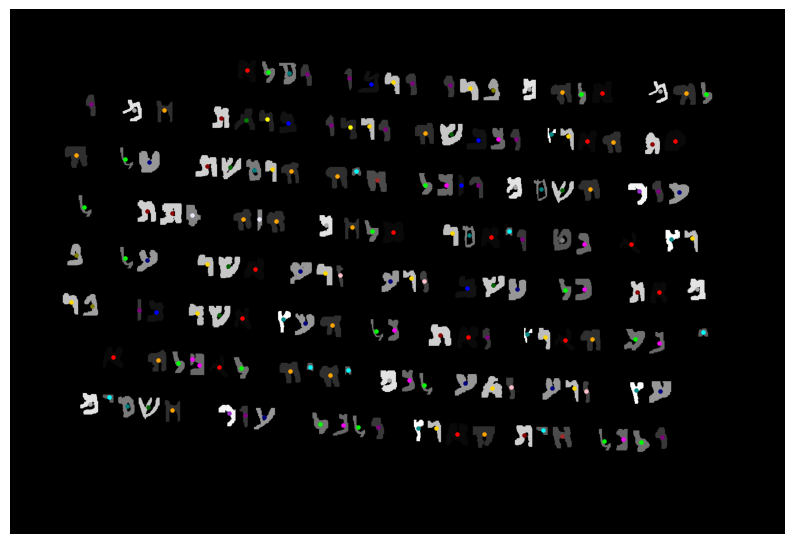

In [6]:
import matplotlib.pyplot as plt

label_to_color = {
    "1": "red",
    "2": "blue",
    "3": "green",
    "4": "yellow",
    "5": "orange",
    "6": "purple",
    "7": "pink",
    "8": "brown",
    "9": "gray",
    "10": "cyan",
    "11": "magenta",
    "12": "lime",
    "13": "teal",
    "14": "lavender",
    "15": "maroon",
    "16": "navy",
    "17": "olive",
    "18": "aqua",
    "19": "limegreen",
    "20": "gold",
    "21": "darkgreen",
    "22": "darkred",
    "23": "darkblue",
    "24": "darkgray",
    "25": "darkorange",
    "26": "darkorchid",
    "27": "darkcyan",
}


def plot_points_on_image(img: np.ndarray, points, label_to_color):
    plt.figure(figsize=(10, 10))  # Set the figure size, you can adjust this as needed
    plt.imshow(img, cmap='gray')  # Display the image in grayscale

    for point in points:
        plt.scatter(point.y, point.x, s=5, color=label_to_color[str(point.label)])

    plt.axis('off')  # remove the axis
    plt.show()  # show the plot


plot_points_on_image(image_without_ornaments, points, label_to_color)


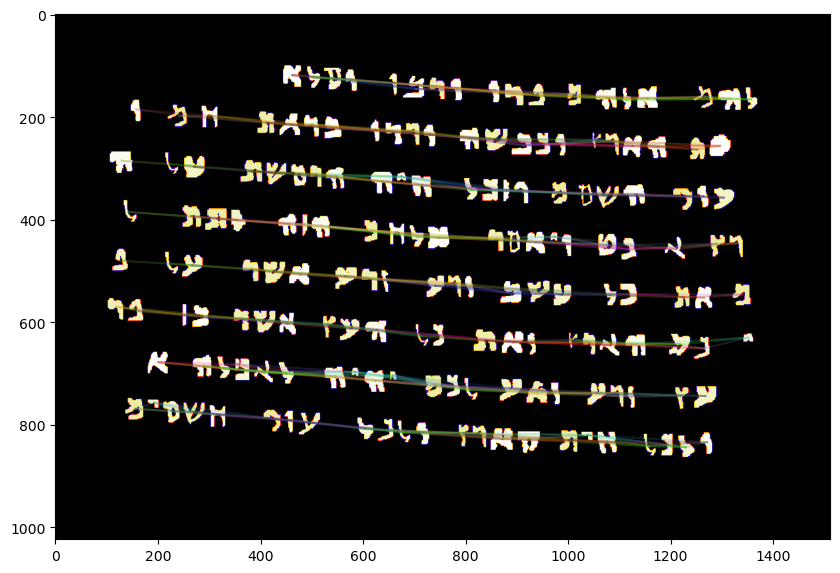

In [7]:
def construct_graph(points, dist_x=50, dist_y=250):
    graph = {}
    for u in points:
        graph[u] = []
        for v in points:
            if u == v:
                continue

            d_x = abs(u.x - v.x)
            d_y = abs(u.y - v.y)
            
            if d_x <= dist_x and d_y <= dist_y:
                graph[u].append(v)
    return graph

graph = construct_graph(points)

def plot_graph(img: np.ndarray, graph, label_to_color):
    plt.figure(figsize=(10, 10))  # Set the figure size, you can adjust this as needed
    plt.imshow(-img, cmap='CMRmap')  # Display the image in grayscale

    for u, neighbors in graph.items():
        for v in neighbors:
            plt.plot([u.y, v.y], [u.x, v.x], color=label_to_color[str(u.label)], alpha=0.1)

    # plt.axis('off')  # remove the axis
    plt.show()  # show the plot

plot_graph(image_without_ornaments, graph, label_to_color)

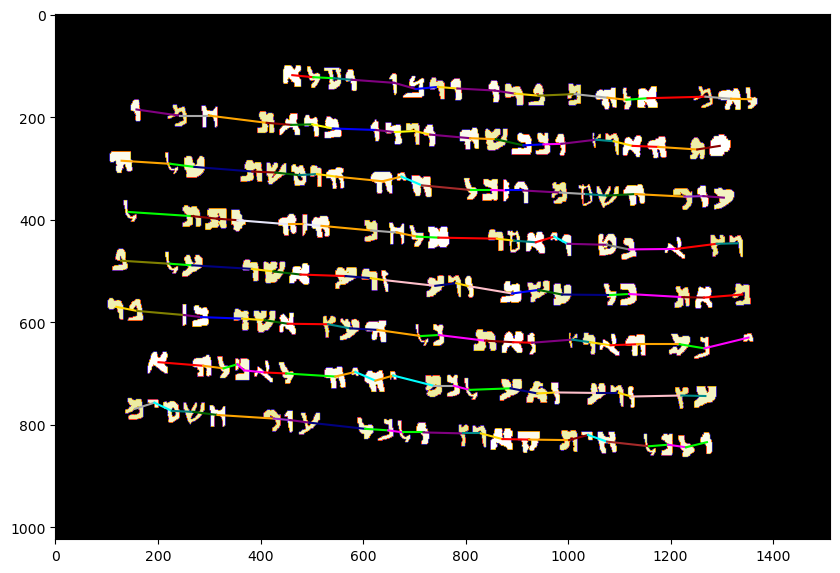

In [50]:
def transpose_points(points):
    return [Point(point.y, point.x, point.label) for point in points]

def plot_lines(img: np.ndarray, lines, label_to_color):
    plt.figure(figsize=(10, 10))  # Set the figure size, you can adjust this as needed
    plt.imshow(-img, cmap='CMRmap')  # Display the image in grayscale

    for line in lines:
        for i in range(len(line) - 1):
            u = line[i]
            v = line[i + 1]
            plt.plot([u.y, v.y], [u.x, v.x], color=label_to_color[str(u.label)], alpha=1)

    # plt.axis('off')  # remove the axis
    plt.show()  # show the plot

def find_best_line(graph, line):
    """
    Recursively find the best line 
    Args:
        graph: the graph
        line: the current line so far starting with [p0, p1, ..., pn] sorted by x coordinate
    Returns:
        the best line starting with [starting_point], fitness of the line
    """

    def get_started_points(line):
        # Mark the ends of the line
        starting_points = [line[-1]]
        if len(line) != 1:
            starting_points.append(line[-2])
        return starting_points
    
    def point_in_bounds(point, line):
        # Line bounds for pruning 
        min_x = min([p.x for p in line])
        max_x = max([p.x for p in line])
        return point.x >= min_x and point.x <= max_x

    prev_starting_points = None
    starting_points = get_started_points(line)

    while prev_starting_points != starting_points:
        for starting_point in starting_points:
            neighbors = [p for p in graph[starting_point] if not point_in_bounds(p, line)]

            if len(neighbors) == 0:
                continue
            closest_neighbor = min(neighbors, key=lambda p: abs(p.x - starting_point.x))
            new_line = line + [closest_neighbor]
            new_line = sorted(new_line, key=lambda p: p.x)
            line = new_line

        prev_starting_points = starting_points
        starting_points = get_started_points(line)
        
    return line

def extract_lines(graph):
    lines = []

    _graph = graph.copy()        
    while len(_graph) > 0:
        # take point with max y
        starting_point = min(_graph.keys(), key=lambda p: p.x)
        # starting_point = random.choice(list(_graph.keys()))
        line = find_best_line(_graph, [starting_point])
        lines.append(line)
        
        # remove points from graph
        for point in line:
            # remove references to this point
            for neighbors in _graph.values():
                if point in neighbors:
                    neighbors.remove(point)
            del _graph[point]

    return lines

ps = transpose_points(points)
graph = construct_graph(ps, dist_x=250, dist_y=50)
lines = extract_lines(graph)
lines = [transpose_points(line) for line in lines]

plot_lines(image_without_ornaments, lines, label_to_color)